## The irreducible mass of black holes.

Consider a rotating black hole. In [1969](https://ui.adsabs.harvard.edu/abs/1969NCimR...1..252P/abstract), Roger Penrose (now [Nobel Prize in Physics](https://www.nobelprize.org/prizes/physics/2020/penrose/facts/) for the theory of black holes) discovered that one can extract energy from a rotating black hole:

![](https://inspirehep.net/files/268d28446b405e134199d84f67c23792)

(figure from [Harada, Kimura 2014](https://ui.adsabs.harvard.edu/abs/2014CQGra..31x3001H/abstract)).

Maybe some of you has seen this already in your GR class? In any case, a rotating black-hole has a region called ergosphere such that infalling particles have negative energy. Penrose imagined a particle that enters that region and decays: half will fall in and half will escape to infinity, carring some energy with it. In a nutshell, we've extracted energy=mass from a black hole! It turns out that one also has to extract angular momentum, not just energy (and here you'll need some GR do to this calculation, see e.g. the famous textbook by [Misner, Thorne and Weeler](https://press.princeton.edu/books/hardcover/9780691177793/gravitation)). But angular momentum runs out first, such that a repeated series of Penrose processes leaves behind a non-rotating BH with a remnant mass which is called "irreducible". This is a famous result by [Christodoulou 1970](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.25.1596) and is closely related to the even more famous area law by [Hawking (1971)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.26.1344) (which in turns is the foundation of black-hole thermodynamics -- for you, my theorethical physics friend).


For a BH of mass $M$ spin $\chi\in [0,1]$, the irreducible mass is 
\begin{equation}
M_{\rm irr} = %\sqrt{\frac{M^2+\sqrt{M^4-S^2}}{2}} = 
 M \sqrt{\frac{1+\sqrt{1-\chi^2}}{2}}
\label{mirrdef}
\end{equation}
For convenience, let us define 

$$f(\chi) = \sqrt{\frac{1+\sqrt{1-\chi^2}}{2}} = \frac{M_{\rm irr}}{M}$$

Suppose you have repeated measurments of $M$ and $\chi$. This is just because we're still frequentists for now. When we will put our Bayesian hat on, these distributions will be the *posterior samples* from a single measurement.

Let's assume that

- the spin $\chi$ is uniformly distributed between 0 and 1.
- the mass $M$ is normally distributed with mean $\mu$ and standard deviation $\sigma$.

These are simplistic assumption that, however, are not too far from what we are now measuring with gravitational-wave detectors. It's a toy model, but not a totally unreasonable one.




In [1]:
import numpy as np
from matplotlib import pyplot as plt

import scipy.stats
from scipy import optimize
from scipy.stats import norm
from scipy.stats import uniform

from astroML import stats as astroMLstats
from astropy.visualization.hist import hist as fancyhist

from sklearn.neighbors import KernelDensity

**Tasks**:

1. Start with a value of $\sigma=0.02$. Note that $\mu$ is a scale and not a parameter: you can normalize all quantities with a dimension of mass by $\mu$. Just set $\mu=1$ in your code and remember that all masses in the problem are measured in units of $\mu$. 

In [2]:
# define the function for M_irr:

def M_irr(M,chi):
    return M*np.sqrt((1+np.sqrt(1-chi**2))/2)

def f(M,chi):
    return M_irr(M,chi)/M

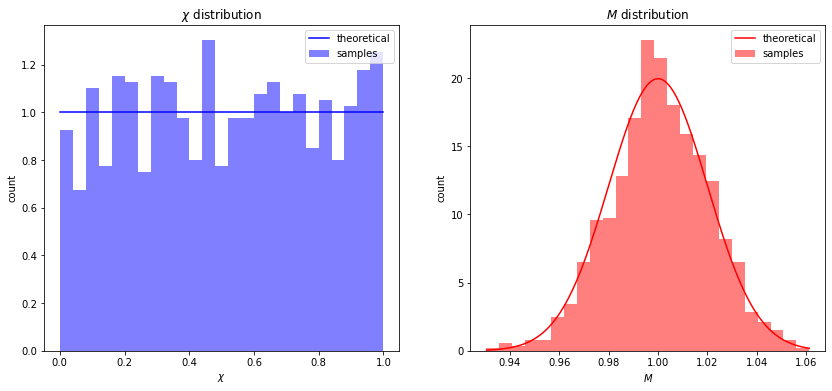

In [71]:
N = 1000 # number of measurements

# generate data for chi and M:
chi_distr = np.random.uniform(0,1,N)

mu = 1 # this is just a scale
sigma = 0.02
M_distr = np.random.normal(mu,sigma,N)

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(14,6))

# plot the 'sample' distributions:
ax[0].hist(chi_distr,bins=25,histtype='stepfilled',color='blue',alpha=0.5,density=True,label='samples')

chi_grid = np.linspace(min(chi_distr),max(chi_distr),1000)
ax[0].plot(chi_grid,scipy.stats.uniform(0,1).pdf(chi_grid),color='blue',label='theoretical')

ax[0].set_title(r'$\chi$ distribution')
ax[0].set_xlabel(r'$\chi$')
ax[0].set_ylabel('count')
ax[0].legend()

ax[1].hist(M_distr,bins=25,histtype='stepfilled',color='red',alpha=0.5,density=True,label='samples')

M_grid = np.linspace(min(M_distr),max(M_distr),1000)
ax[1].plot(M_grid,scipy.stats.norm(mu,sigma).pdf(M_grid),color='red',label='theoretical')

ax[1].set_title(r'$M$ distribution')
ax[1].set_xlabel(r'$M$')
ax[1].set_ylabel('count')
ax[1].legend()

2. Plot the resulting pdf of $M_{\rm irr}$. First try an histogram with one the rules of thumb we've seen above:

**"Scott's rule"** suggests that the optimal bin width is 

$$\Delta_b = \frac{3.5\sigma}{N^{1/3}}.$$

That's great, but what if we don't know the standard deviation, $\sigma$ (e.g., if the distribution isn't really Gaussian)?  

We can then instead used the **"Freedman-Diaconis rule"**: 

$$\Delta_b = \frac{2(q_{75}-q_{25})}{N^{1/3}} = \frac{2.7\sigma_G}{N^{1/3}}.$$  

*Hint*: You don't know the functional form of the pdf of $M_{\rm irr}$... but you don't need it if you just want to generate samples! That's the nice thing about numerics!

In [40]:
# compute the f and M_irr distributions:

f_distr = f(M_distr,chi_distr)
M_irr_distr = M_irr(M_distr,chi_distr)

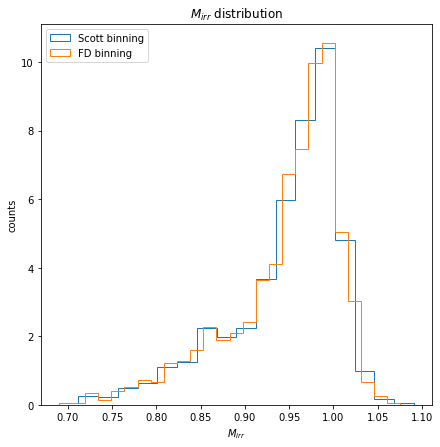

In [41]:
# try to plor an histo with the Scott's and Freedman-Diaconis rules:
fig = plt.figure(figsize=(7,7))

fancyhist(M_irr_distr, bins="scott", histtype="step",density=True,label='Scott binning');
fancyhist(M_irr_distr, bins="freedman", histtype="step",density=True,label='FD binning');

plt.title(r'$M_{irr}$ distribution')
plt.xlabel(r'$M_{irr}$')
plt.ylabel('counts')
plt.legend(loc='upper left')
plt.show()

3. Using the same samples, plot the distribution of $M_{\rm irr}$ using a KDE.

In [6]:
# define the best bandwith through cross-validation:
from sklearn.model_selection import GridSearchCV

bw_range = np.linspace(0.001,1,100) # define the bandwidth range for the search

grid = GridSearchCV(KernelDensity(kernel='gaussian'),param_grid={'bandwidth': bw_range},cv=5,n_jobs=-1) # define the gridSearch object

grid.fit(M_irr_distr[:,np.newaxis]) # fit the gridsearch on our data

print('best bandwidth:',grid.best_estimator_.bandwidth)

best bandwidth: 0.011090909090909092


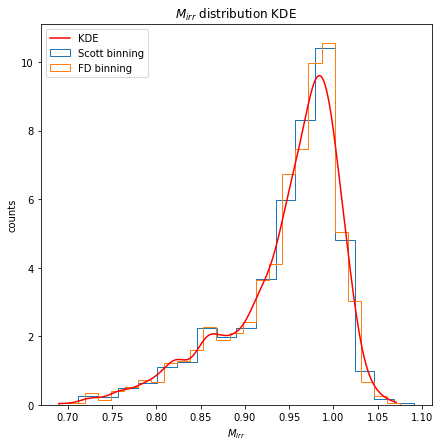

In [42]:
# define the KDE with the best bw:
best_bw = grid.best_estimator_.bandwidth
xgrid = np.linspace(M_irr_distr.min(),M_irr_distr.max(),N)  # Use this instead of 'x' for plotting

kde =  KernelDensity(bandwidth=best_bw,kernel='gaussian')
kde.fit(M_irr_distr[:,np.newaxis])

pdf_kde = np.exp(kde.score_samples(xgrid[:, np.newaxis]))

# plot
fig = plt.figure(figsize=(7,7))

fancyhist(M_irr_distr, bins="scott", histtype="step",density=True,label='Scott binning');
fancyhist(M_irr_distr, bins="freedman", histtype="step",density=True,label='FD binning');

plt.plot(xgrid, pdf_kde,color='red',label='KDE')

plt.title(r'$M_{irr}$ distribution KDE')
plt.xlabel(r'$M_{irr}$')
plt.ylabel('counts')
plt.legend(loc='upper left')
plt.show()

4. Compute the KS distance between ${M_{\rm irr}}$ and ${f}$ as a function of $\sigma$. Discuss the limits at large and small values of $\sigma$. 

5. Compute the KS distance between ${M_{\rm irr}}$ and $M$ as a function of $\sigma$. Discuss the limits at large and small values of $\sigma$.


The KS test is based on a statistic that measures the maximum difference in the cdfs of our two samples

$$ D = \mathrm{max}|F_1(x1) - F_2(x2)|$$

where $0\leq D\leq 1$. 

> The core idea is to know how often the value of $D$ computed from our data would arise by chance if both samples were drawn from the same distribution (which is our *null hypothesis* here). 

The probability of obtaining a value of $D$ larger than that observed in our data is

$$ Q_\mathrm{KS}(\lambda) = 2\sum_{k=1}^\infty (-1)^{k-1}\exp(-2k^2\lambda^2)$$

where 

$$\lambda = \left(0.12 + \sqrt{n_e} + \frac{0.11}{\sqrt{n_e}} \right)D $$

and the ***effective number of data points***, $n_e$, is

$$ n_e = \left( \frac{1}{N_1} + \frac{1}{N_2}\right)^{-1} = \frac{N_1 N_2}{N_1 + N_2}$$

If the probability that $D$ were drawn by chance is very small (low $p$-value) then we can reject the null hypothesis that the two samples were drawn from the same distribution.

For large $n_e$ we have $\lambda\approx\sqrt{n_e}D$. In fact, for $n_e>10$ we can bypass $Q_\mathrm{KS}$ entirely and **compute the value of D that would correspond to a given significance level $\alpha$**,

$$ D_\mathrm{KS} = \frac{C(\alpha)}{\sqrt{n_e}}$$

where $C(\alpha) = \sqrt{-\frac{1}{2}\ln(\alpha/2)}$. 

In [8]:
# sigma values:
sigmas = np.array([0.001,0.01,0.1,1,10,100])
mu = 1 # this is just a scale

In [9]:
# compute KS distance for different values of sigma:
D_KS_mIrr_f = []
D_KS_mIrr_M = []

p_KS_mIrr_f = []
p_KS_mIrr_M = []

for s in sigmas:
    # generate data for chi and M:
    chi_d = np.random.uniform(0,1,N)
    M_d = np.random.normal(mu,s,N)

    # extract the M_irr distribution:
    M_irr_distr_s = M_irr(M_d,chi_d)
    f_distr_s = f(M_d,chi_d)
    
    # compute the KS-test: D and pvalue
    
    D_f,p_value_f = scipy.stats.ks_2samp(M_irr_distr_s,f_distr_s)
    D_M,p_value_M = scipy.stats.ks_2samp(M_irr_distr_s,M_d)
    
    D_KS_mIrr_f.append(D_f)
    D_KS_mIrr_M.append(D_M)
    
    p_KS_mIrr_f.append(p_value_f)
    p_KS_mIrr_M.append(p_value_M)


6. You should find that (i) $M_{\rm irr}$ is distributed like $f$ if ${\sigma}\ll \mu$ and (ii) $M_{\rm irr}$ is distributed like $M$ if  $\sigma\gg \mu$.

Text(0, 0.5, '$KS$ distance')

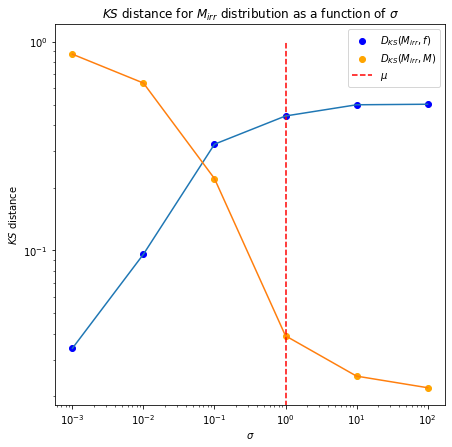

In [10]:
fig = plt.figure(figsize=(7,7))

plt.scatter(sigmas,D_KS_mIrr_f,label='$D_{KS}(M_{irr},f)$',color='blue')
plt.plot(sigmas,D_KS_mIrr_f)

plt.scatter(sigmas,D_KS_mIrr_M,label='$D_{KS}(M_{irr},M)$',color='orange')
plt.plot(sigmas,D_KS_mIrr_M)

plt.vlines(mu,0,1,color='red',linestyle='--',label=r'$\mu$')

plt.loglog()
plt.legend()
plt.title(r'$KS$ distance for $M_{irr}$ distribution as a function of $\sigma$')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$KS$ distance')

Text(0, 0.5, '$KS$ p-value')

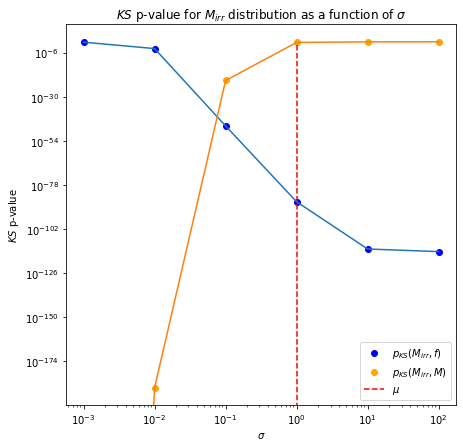

In [11]:
fig = plt.figure(figsize=(7,7))

plt.scatter(sigmas,p_KS_mIrr_f,label='$p_{KS}(M_{irr},f)$',color='blue')
plt.plot(sigmas,p_KS_mIrr_f)

plt.scatter(sigmas,p_KS_mIrr_M,label='$p_{KS}(M_{irr},M)$',color='orange')
plt.plot(sigmas,p_KS_mIrr_M)

plt.vlines(mu,0,1,color='red',linestyle='--',label=r'$\mu$')

plt.loglog()
plt.legend()
plt.title(r'$KS$ p-value for $M_{irr}$ distribution as a function of $\sigma$')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$KS$ p-value')

7. Compute the pdfs of $M_{\rm irr}$ from their mathematical definitions, plot them, and check they agree with your KDE.

*Hint (for point 7 above)*: First compute the pdf of $f$, that is just a change of variable. We saw how to do this in a previous lecture. The answer is:
\begin{equation}
\pi(f) = 2\frac{2 f^2-1}{\sqrt{1 - f^2}}\,.
\end{equation}

*Another hint (still for point 7 above)*: Then compute the pdf of $M_{\rm irr}$, you want to use [this theorem](https://en.wikipedia.org/wiki/Distribution_of_the_product_of_two_random_variables) for the product of two random variables. The answer is only semi-analytic (unless you know how to solve that integral? If so please tell me!)
\begin{equation}
p(M_{\rm irr})  = \frac{\sqrt{2/\pi}}{\sigma} \int_{1/\sqrt{2}}^1 \exp\left[{-\frac{(M_{\rm irr}/f -\mu)^2}{2\sigma^2}}\right]  \frac{2 f^2-1}{f \sqrt{1 - f^2}}  \,\, {\rm d}f\,. \label{pmirr}
\end{equation}
This can be easily solved numerically.

*Yet another hint:* If any any time you get lost in the calculation, it helps checking that your pdfs are normalized as they should.

In [100]:
# analytical distributions: f and M_irr
def f_pdf(f):  
    '''computed by change of variable from chi uniform distribution between [0,1]'''
    return 2*(2*f**2 - 1)/(np.sqrt(1-f**2))

def M_irr_pdf(f,M_irr,mu,sigma):
    '''computed as the product of two continuous, independent random variables'''
    
    m_irr = np.zeros(len(M_irr))
    
    for m,i in zip(M_irr,range(len(M_irr))):
        norm = 1/sigma * np.sqrt(2/np.pi)
        func = (2*f**2 - 1)/(f*np.sqrt(1-f**2)) * np.exp(- (m/f - mu)**2 / (2*sigma**2))
        
        m_irr[i] = norm * np.trapz(func,f)
    
    return m_irr[np.argsort(M_irr)]

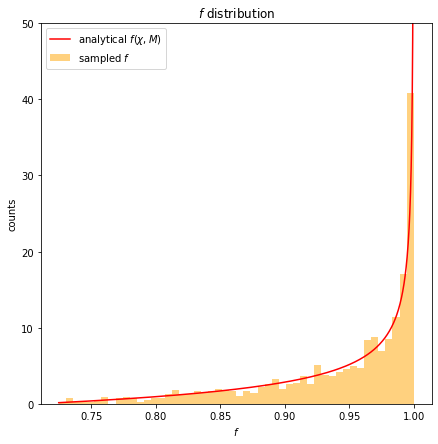

In [101]:
# let's study the analytical solutions with the initial definition of sigma:
f_an = f_pdf(np.sort(f_distr))

fig=plt.figure(figsize=(7,7))

plt.hist(f_distr,bins=50,density=True,label='sampled $f$',color='orange',alpha=0.5)
plt.plot(np.sort(f_distr),f_an,color='red',label='analytical $f(\chi,M)$')

plt.xlabel(r'$f$')
plt.ylabel('counts')
plt.title(r'$f$ distribution')
plt.ylim(0,50)
plt.legend()

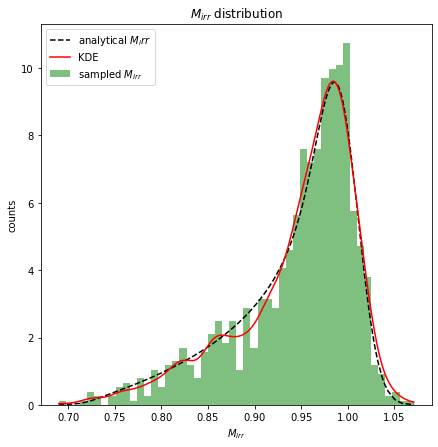

In [106]:
# compute the analytical pdf for M_irr
M_irr_an = M_irr_pdf(np.sort(f_distr),M_irr_distr[np.argsort(f_distr)],mu,sigma)

# plot
fig = plt.figure(figsize=(7,7))

plt.hist(M_irr_distr,bins=50,density=True,label='sampled $M_{irr}$',color='green',alpha=0.5)
plt.plot(np.sort(M_irr_distr),M_irr_an,color='black',label='analytical $M_irr$',linestyle='--')
plt.plot(xgrid, pdf_kde,color='red',label='KDE')

plt.xlabel(r'$M_{irr}$')
plt.ylabel('counts')
plt.title(r'$M_{irr}$ distribution')
plt.legend()

Maybe a little bit of overfitting with the KDE?

# Stuff

In [18]:
xgrid = np.linspace(M_irr_distr_np.min(),M_irr_distr_np.max(),N)  # Use this instead of 'x' for plotting

def kde_sklearn(data, bandwidth = 1.0, kernel="linear"):
    kde_skl = KernelDensity(bandwidth = bandwidth, 
                            kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)

    return np.exp(log_pdf)

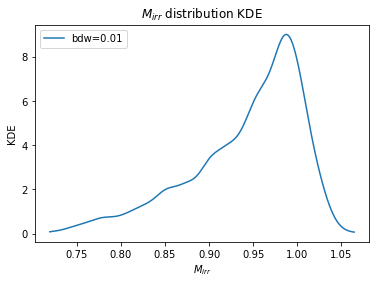

In [27]:
bdw = 0.01
gauss_kde = kde_sklearn(M_irr_distr_np,bandwidth=bdw,kernel="gaussian") 
plt.plot(xgrid,gauss_kde,label='bdw=%.2f'%bdw) 
plt.title(r'$M_{irr}$ distribution KDE')
plt.xlabel(r'$M_{irr}$')
plt.ylabel('KDE')
plt.legend(loc='upper left')
plt.show()

In [ ]:
for M,chi in zip(M_d,chi_d):
        M_irr_distr.append(M_irr(M,chi))
        f_distr.append(f(M,chi))
    
    D_mIrr_f = max(abs(np.cumsum(M_irr_distr) - np.cumsum(f_distr)))
    D_mIrr_M = max(abs(np.cumsum(M_irr_distr) - np.cumsum(M_d)))
    
    D_KS_mIrr_f.append(D_mIrr_f)
    D_KS_mIrr_M.append(D_mIrr_M)